# 필요한 라이브러리 불러오기

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# 이미지 불러오기

(960, 720, 3)


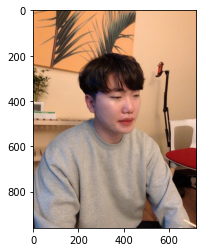

In [4]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/KakaoTalk_20220809_112633178.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 모델 불러오기

In [7]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ffa1c0e2cd0>)

In [8]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [9]:
segvalues, output = model.segmentAsPascalvoc(img_path)

segmantAsPascalvoc의 라벨

In [12]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

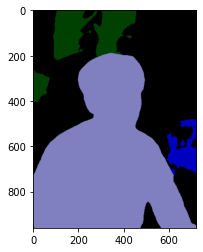

In [13]:
plt.imshow(output)
plt.show()

현재 사진에 있는 라벨들 출력하기

In [14]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person
pottedplant


In [15]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

인물의 컬러맵 출력

In [16]:
colormap[15]

array([192, 128, 128])

BGR2RGB

In [17]:
seg_color = (128,128,192)

(960, 720)


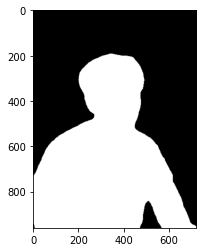

In [18]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

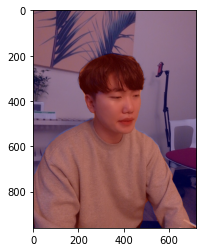

In [19]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 흐리게 만들기

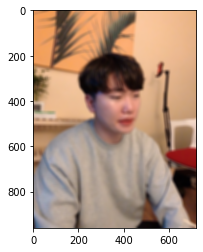

In [22]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
# blurring kernel size를 키우면 블러가 진하게 됨을 확인할 수 있다.
img_orig_blur = cv2.blur(img_orig, (15,15))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

배경만 추출하기

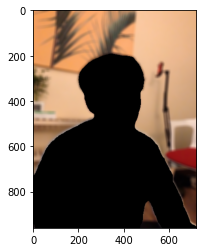

In [23]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 원본과 배경 합성

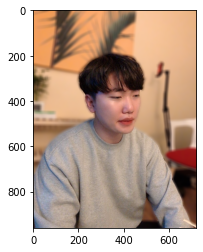

In [24]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 문제점

블러를 진하게 진행해서 사람을 정확하게 파악할 수 없다.

# 개선

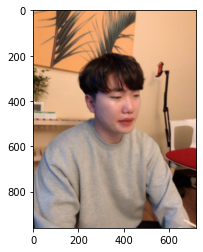

In [25]:
img_orig_blur1 = cv2.blur(img_orig, (5,5))  
plt.imshow(cv2.cvtColor(img_orig_blur1, cv2.COLOR_BGR2RGB))
plt.show()

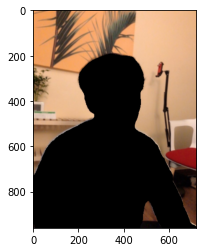

In [26]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur1 = cv2.bitwise_and(img_orig_blur1, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur1, cv2.COLOR_BGR2RGB))
plt.show()

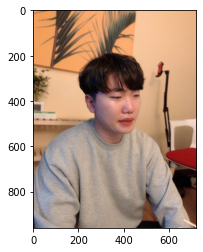

In [27]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur1)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

blur를 옅게 하니까 인물 사진이 좀 더 잘 나오는 것 같다.

# 다른 사진으로 인물 모드 만들기

(437, 510, 3)


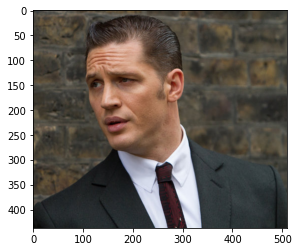

In [28]:
img_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/톰하디.jpg'  
img_orig1 = cv2.imread(img_path1) 

print(img_orig1.shape)
plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
plt.show()

In [29]:
model.load_pascalvoc_model(model_file)
segvalues, output = model.segmentAsPascalvoc(img_path1)

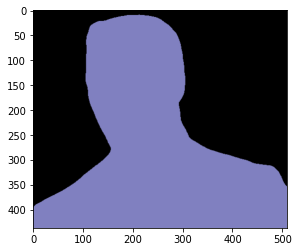

In [30]:
plt.imshow(output)
plt.show()

In [31]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [32]:
colormap[15]

array([192, 128, 128])

In [35]:
seg_color1 = (128,128,192)

(437, 510)


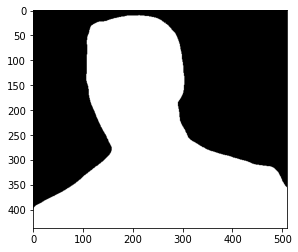

In [36]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map1 = np.all(output==seg_color1, axis=-1)
print(seg_map1.shape)
plt.imshow(seg_map1, cmap='gray')
plt.show()

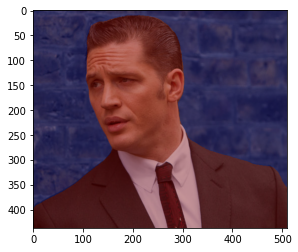

In [39]:
img_show1 = img_orig1.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask1 = seg_map1.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask1 = cv2.applyColorMap(img_mask1, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show1 = cv2.addWeighted(img_show1, 0.6, color_mask1, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show1, cv2.COLOR_BGR2RGB))
plt.show()

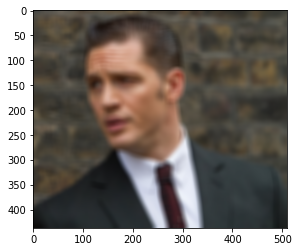

In [47]:
img_orig_blur2 = cv2.blur(img_orig1, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.show()

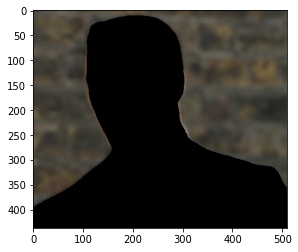

In [48]:
img_mask_color1 = cv2.cvtColor(img_mask1, cv2.COLOR_GRAY2BGR)
img_bg_mask1 = cv2.bitwise_not(img_mask_color1)
img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask1)
plt.imshow(cv2.cvtColor(img_bg_blur1, cv2.COLOR_BGR2RGB))
plt.show()

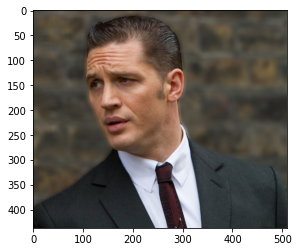

In [49]:
img_concat1 = np.where(img_mask_color1==255, img_orig1, img_bg_blur2)
plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB))
plt.show()

# 톰하디 사진 문제점

인물과 배경만 있어서 segmentation model이 잘 작동하는 것을 감지할 수 있다.

# segmantation model 전반적인 해결 방안

인물 모드 사진 찍기는 인물에 초점을 두고 다른 것은 아웃포커싱 하는 기법이다. \
이를 카메라 성능 부분과 다른 소프트웨어의 교체 두 부분으로 해결할 수 있다.\
우선, 카메라 성능 부분은 조리개 성능 향상과 이미지센서(D-toF)를 사용하는 것이다.\
아웃포커스는 조리개를 통해 빛을 많이 받아서 사진을 찍는 기법이기에 조리개 성능 향상이 필수적이다.
D-ToF 방식은 펄스 레이저를 사물에 조사해 반사된 펄스 신호들이 이미지센서에 도착하는 시간을 측정함으로써 물체까지의 거리를 탐지하는 방식이다.\
수십 혹은 수백 미터 이상 떨어진 물체와의 거리도 측정할 수 있다는 매우 큰 장점을 가지고 있으나, 이를 위해서는 초고효율 특성을 제공하는 소자인 단광자눈사태다이오드(Single-Photon Avalanche Diode, SPAD)가 필수적으로 요구된다.

소프트웨어적인 측면을 고려하면 3D 이미지 센서를 사용하는 만큼 3D로 struct2Depth, udepth와 융합해서 소프트웨어를 만드는 것이 필요하다.

# 출처

Aiffel exploration 9 \
https://news.skhynix.co.kr/post/next-gen-3d

# 회고

오늘 노드를 통해 인물 사진 합성을 해보았다. 이것을 통해서 나는 이미지 세그멘테이션의 일부를 체험해볼 수 있었다. \
이미지에서 픽셀 단위로 관심 객체를 추출하는 방법이 이미지 세그멘테이션(image segmentation)이라고 한다.\
이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 ‘공통적인 특징’을 가진다고 가정한다.\
이때 공통 특징은 물리적 의미가 없을 수도 있다.\
픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이다.\
물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출한다.\
세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적인 의미 단위로 인식하는 세그멘테이션을 시맨틱 세그멘테이션이라고 한다.\
쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이라고 이해하시면 된다. \
시맨틱 세그멘테이션을 직접 해보고 이를 위한 개선 방향을 생각하면서 CV가 좀 더 적성에 맞다는 것을 확인했다,\
아직은 조금만 이해했지만 좀 더 공부해 보고 싶다.